In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

TF_CPP_MIN_LOG_LEVEL=0

In [2]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

def conv2D_batchnorm(*args, **kwargs):
    return keras.Sequential([
        layers.Conv2D(*args, **kwargs),
        layers.BatchNormalization(),
        layers.ReLU()
    ])

def basic_block(channel_out):
    return keras.Sequential([
        conv2D_batchnorm(
            channel_out//4, (1, 1), padding="same"
        ),
        conv2D_batchnorm(
            channel_out//4, (3, 1), padding="same"
        ),
        conv2D_batchnorm(
            channel_out//4, (1, 3), padding="same"
        ),
        conv2D_batchnorm(
            channel_out//4, (1, 1), padding="same"
        ),
    ])


In [3]:
class global_context(layers.Layer):
    def __init__(self, ksize, strides):
        super().__init__()
        self.ksize = ksize
        self.strides = strides
    
    def call(self, channel_in):
        x = layers.AveragePooling2D(
            pool_size=self.ksize, strides=self.strides, padding="same"
        )(channel_in)

        cx = layers.Lambda(lambda e: tf.math.square(e))(x)
        cx = layers.Lambda(lambda e: tf.math.reduce_mean(e))(cx)

        out = layers.Lambda(
            lambda e: tf.math.divide(e[0], e[1])
        )([x, cx])

        return out

def lprnet(
    n_classes,
    shape=(24, 94, 3),
):
    input_layer = layers.Input(shape)

    x = conv2D_batchnorm(64, (3, 3), strides=1, padding="same")(input_layer)

    x = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding="same")(x)
    x2 = basic_block(128)(x)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 2), padding="same")(x2)
    x3 = basic_block(256)(x)
    x = basic_block(256)(x3)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 2), padding="same")(x)
    x = layers.Dropout(0.5)(x)

    x = conv2D_batchnorm(256, (4, 1), strides=1, padding="same")(x)

    x = layers.Dropout(0.5)(x)

    x = conv2D_batchnorm(n_classes, (1, 13), padding="same")(x)

    # Global Context
    cx = layers.Lambda(lambda e: tf.math.square(e))(x)
    cx = layers.Lambda(lambda e: tf.math.reduce_mean(e))(cx)
    x0  = layers.Lambda(
        lambda e: tf.math.divide(e[0], e[1])
    )([x, cx])

    x1 = global_context(
        ksize=[1, 4],
        strides=[1, 4],
    )(input_layer)
    x2 = global_context(
        ksize=[1, 4],
        strides=[1, 4],
    )(x2)
    x3 = global_context(
        ksize=[1, 2],
        strides=[1, 2],
    )(x3)

    x = layers.Lambda(
        lambda e: tf.concat([e[0], e[1], e[2], e[3]], 3)
    )([x0, x1, x2, x3])
    x = layers.Conv2D(
        n_classes,
        kernel_size=(1,1),
        strides=(1,1),
    )(x)
    logits = layers.Lambda(
        lambda x: tf.math.reduce_mean(x, axis=1)
    )(x)
    output_layer = layers.Softmax()(logits)


    return keras.Model(input_layer, output_layer)

In [4]:
import constants

CHARS_DICT = {char:i for i, char in enumerate(constants.CHARS)}
N_OUTPUTS = len(constants.CHARS) + 1

print(f"N_OUTPUTS: {N_OUTPUTS}")

model = lprnet(N_OUTPUTS)
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(
    1e-3, 
    decay_steps=500,
    decay_rate=0.995,
    staircase=True
)
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate_scheduler
    ),
    loss=ctc_loss
)

N_OUTPUTS: 67


2022-02-14 11:32:49.134666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 11:32:49.743578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 11:32:49.743892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 11:32:49.779195: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
import os
import cv2

TRAIN = "data/train"
VAL = "data/val"
TEST = "data/test"

In [6]:
import os
import cv2

from classes.data_generator import *

TRAIN = "data/train"
VAL = "data/val"
TEST = "data/test"

# Generators
training_generator = DataGenerator(
    os.listdir(TRAIN),
    TRAIN
)
validation_generator = DataGenerator(
    os.listdir(VAL),
    VAL
)

callbacks=[
    keras.callbacks.EarlyStopping(
        monitor="val_loss", mode="min", patience=10
    ),
]

model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    callbacks=callbacks
)

2022-02-14 11:33:05.795196: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


3125/3125 [==============================] - 2000s 635ms/step - loss: 2.3354 - val_loss: 0.4952


In [7]:
model.save('full')

2022-02-14 12:06:20.279725: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: full/assets


data/test/30390-12_41_57_33_32_37_37.jpg
(24, 94, 3)
data/test/12360-12_41_59_62_33_32_37.jpg
(24, 94, 3)
data/test/89935-12_41_62_31_58_32_39.jpg
(24, 94, 3)
(3, 24, 94, 3)


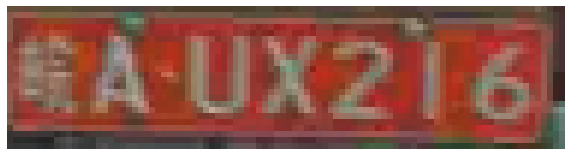

In [8]:
import matplotlib.pyplot as plt

test_data_fnames = os.listdir(TEST)[:3]
test_data_fnames = list(map(
    lambda e : os.path.join(TEST, e),
    test_data_fnames
))
test_imgs = []
for fname in test_data_fnames:
    print(fname)
    img = cv2.imread(fname)
    img = cv2.resize(img, (94, 24))/256
    print(img.shape)
    test_imgs.append(img)
test_imgs = tf.convert_to_tensor(test_imgs)
print(test_imgs.shape)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.imshow(test_imgs[1])

In [9]:
import constants

def decode_output(prediction):
    prediction = np.expand_dims(prediction,axis=0)
    ctc_decoded = keras.backend.ctc_decode(prediction, (24,))
    flattened = np.array(ctc_decoded[0]).reshape(24)
    lpn = [
        constants.CHARS[e] 
        for e in flattened
        if e > -1
    ]
    return "".join(lpn)


preds = model.predict(test_imgs)
lpn = decode_output(preds[1])
print(lpn)

皖AUX216


In [10]:
test_generator = DataGenerator(
    os.listdir(TEST),
    TEST
)
model.evaluate_generator(test_generator)

0.4952451288700104